## Analisis de Sentimientos
### Josseline Perdomo e Ybrahin Martinez

- Introdución
- Análisis Exploratorio
- Preprocesamiento
- Algoritmo Utilizado
- Aplicación
- Conclusión

### Introdicción

- La cantidad de contenido generado por los usuarios en Internet ha aumentado de manera exponencial en la última década.
- Ahora toda nuestra toma de decisiones tiende a ser social.
- Es un tema difícil en el aprendizaje automático.
- Esto puede ser útil a compañías de proveedores de servicios.

In [1]:
# -*- coding: utf-8 -*-
# Versión del proyecto para análisis de modelos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import re, string

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn import cross_validation
from sklearn import metrics

# Data de entrenamiento
namefile = "../dat/labeledTrainData.tsv"

In [2]:
def preprocessing(raw_review, lang = "english"):
    tknzr = TweetTokenizer(reduce_len = True)
    
    raw_review = re.sub ("<br\s*\/>", " ", raw_review)
    raw_review = re.sub ("\\\\","", raw_review)
    raw_review = re.sub ("\"","", raw_review)
    
    if lang == "english":
        raw_review = re.sub("\'","", raw_review)
        
    words = tknzr.tokenize(raw_review)
    punctuation = list(string.punctuation)
    
    stops = set(stopwords.words(lang) + punctuation)
    words = [word for word in words if not word.lower() in stops]
    
    return (" ".join(words))

def get_model(y, bag_of_words, vectorizer, n = 100, **kwargs):
    vec_model = vectorizer(**kwargs)
    vec = vec_model.fit_transform(bag_of_words).toarray()
    forest = RandomForestClassifier(n_estimators = n).fit(vec, y)
    
    return {"vector": vec_model, "model": forest}

def plot_confusion_matrix(cm, title="Confusion matrix"):
    plt.title(title)
    fig = sns.heatmap(cm, annot = True,  fmt = "d", linewidths = .5, cmap = "YlGnBu")
    fig.set(xlabel = "Prediction", ylabel = "Real")

In [3]:
dataset = pd.read_csv(namefile,
                      header = 0,
                      delimiter = "\t",
                      quoting = 3)
dataset.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
# Preprocesamiento
# Generanado Bag-of-Words
dataset["tokens"] = dataset.review.apply(preprocessing)

dataset.head()

,id,sentiment,review,tokens
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff going moment MJ ive started listening mu...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",Classic War Worlds Timothy Hines entertaining ...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film starts manager Nicholas Bell giving welco...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assumed praised film greatest filmed oper...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",Superbly trashy wondrously unpretentious 80s e...


In [5]:
# Se puede observar que las clases son balanceadas
print dataset.sentiment.value_counts()
print "\n"

# Particionando dataset
train, test = cross_validation.train_test_split(dataset, 
                                                stratify = dataset.sentiment)
# 75% del dataset
print train["sentiment"].value_counts()
print "\n"

# 25% del dataset
print test["sentiment"].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64


1    9375
0    9375
Name: sentiment, dtype: int64


1    3125
0    3125
Name: sentiment, dtype: int64


In [6]:
# Generando modelo cv a partir de train
cv = get_model(train.sentiment, 
               train.tokens,
               CountVectorizer,
               analyzer = "word",
               tokenizer = None,
               preprocessor = None,
               stop_words = None,
               max_features = 5000)

cv["result"] = cv["model"].predict(cv["vector"].transform(test.tokens))

In [7]:
# Generando modelo tfidf a partir de train
tfidf = get_model(train.sentiment,
                  train.tokens,
                  TfidfVectorizer,
                  analyzer = "word",
                  tokenizer = None,
                  min_df = 2,
                  max_df = 0.95,
                  max_features = 5000,
                  sublinear_tf = True)

tfidf["result"] = tfidf["model"].predict(tfidf["vector"].transform(test.tokens))

Count Vectorize - Accuracy Score: 0.84

Count Vectorize - Others Metrics:
              precision    recall  f1-score   support

          0       0.83      0.85      0.84      3125
          1       0.84      0.82      0.83      3125

avg / total       0.84      0.84      0.84      6250




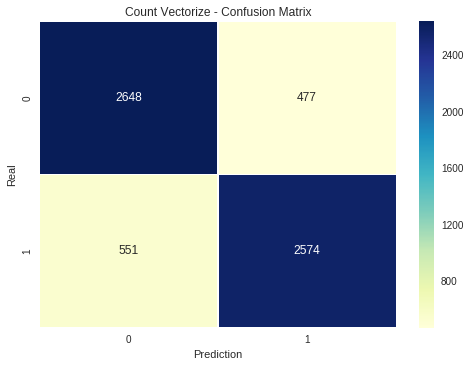

In [8]:
# Evaluando modelo cv
# Confusion Matrix
plot_confusion_matrix(metrics.confusion_matrix(test.sentiment, cv["result"]), 
                     title = "Count Vectorize - Confusion Matrix")
# Accuracy score
print "Count Vectorize - Accuracy Score: {:.2f}\n".format(metrics.accuracy_score(test.sentiment, cv["result"]))

# Others Metrics
print "Count Vectorize - Others Metrics:\n {}\n".format(metrics.classification_report(test.sentiment, cv["result"]))

TFIDF - Accuracy Score: 0.84

TFIDF Vectorize - Others Metrics:
              precision    recall  f1-score   support

          0       0.83      0.85      0.84      3125
          1       0.85      0.83      0.84      3125

avg / total       0.84      0.84      0.84      6250




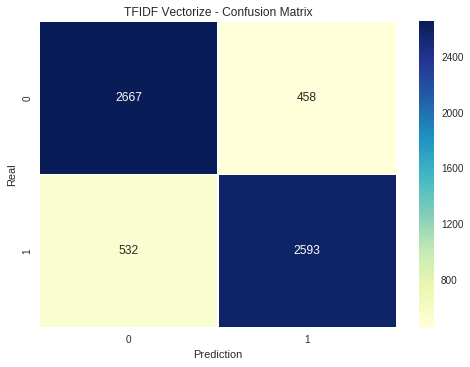

In [9]:
# Evaluando modelo tfidf
# Confusion Matrix
plot_confusion_matrix(metrics.confusion_matrix(test.sentiment, tfidf["result"]), 
                     title = "TFIDF Vectorize - Confusion Matrix")
# Accuracy score
print "TFIDF - Accuracy Score: {:.2f}\n".format(metrics.accuracy_score(test.sentiment, tfidf["result"]))

# Others Metrics
print "TFIDF Vectorize - Others Metrics:\n {}\n".format(metrics.classification_report(test.sentiment, tfidf["result"]))